## Modelo Futuros Mini Ibovespa - Dados Históricos


O Mercado Futuro é o ambiente onde você pode ganhar com a alta ou baixa de um determinado ativo, seja ele uma commodity (Milho, Café, Boi Gordo), uma moeda (como o dólar), um Índice (Bovespa, Índice S&P 500) ou mesmo uma taxa de juros. Nele, são negociados contratos futuros.

<br><img src="grafico.jpeg"><br>

O mini índice é um contrato futuro derivado do Índice Bovespa, ou seja, é um ativo que tem como base o sobe e desce desse índice. Como esse tipo de operação envolve **risco considerável** e **oscilações frequentes no mercado**, ela é indicada apenas para aqueles que se encaixam no perfil de investidor arrojado.

Neste trabalho iremos implementar uma RNNs para realizar a predição diária do Mini Índice da Ibovespa.

O dataset **"FuturosMiniBovespa.csv"** possui informações dispostas em colunas :

* **Date**:  Data das operações na bolsa (diária)
* **Close**:  Valor de Fechamento do Índice da Ibovespa (no dia)
* **Open**:  Valor da Abertura do Índice da Ibovespa (no dia)
* **High**:  Valor máximo do Índice da Ibovespa (no dia)
* **Low**:  Valor mínimo do Índice da Ibovespa (no dia)
* **Vol**:  Volume de contratos negociados (no dia)




### Bibliotecas

In [5]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import plotly.graph_objects as go 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ModuleNotFoundError: No module named 'keras'

### Carregando os dados

Vamos começar lendo o arquivo FuturosMiniBovespa.csv em um dataframe do pandas, mas antes vamos dar uma olhadinha no gráfico de variação do último mês do índice Ibovespa.

In [3]:
DataSet=pd.read_csv('FuturosEthereum-teste.csv')

In [4]:
fig = go.Figure(data=[go.Candlestick(x=DataSet['Date'],
                open=DataSet['Open'], high=DataSet['High'],
                low=DataSet['Low'], close=DataSet['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()



NameError: name 'go' is not defined

## Rede Neural Recorrente (RNN)

Antes de avançar para LSTM, primeiro vamos introduzir o conceito de Redes Recorrentes. Elas são redes utilizadas para reconhecer padrões quando os resultados do passado influenciam no resultado atual. Um exemplo disso são as séries temporais, em que a ordem dos dados é muito importante. <br>

Nesta arquitetura, um neurônio tem como entrada seu estado anterior, além das entradas da camada anterior. A imagem abaixo ilustra esta nova modelagem.
<br><img src="Arquitetura RNN.png"><br>

Observe que H representa o estado. Assim, no estado H_1, o neurônio recebe como parâmetro de entrada X_1 e, além disso, seu estado anterior H_0. O principal problema desta arquitetura é que os estados mais antigos são esquecidos muito rapidamente. Ou seja, para sequências em que precisamos lembrar além de um passado imediato, as redes RNNs são limitadas.


### Rede LSTM
Uma rede LSTM tem origem em uma RNN (Rede Neural Recorrente). Mas ela resolve o problema de memória mudando sua arquitetura.

<br><img src="Arquitetura LSTM.png"><br>

Nesta nova arquitetura, cada neurônio possui 3 gates, cada um com uma função diferente. São eles:
* Input Gate
* Output Gate
* Forget Gate

Agora, um neurônio LSTM recebe entradas de seu estado anterior, assim como ocorria na Rede Recorrente:
<br><img src="Desdobramento LSTM.png"><br>


### Agora vamos ler o arquivo do período desejável 

In [4]:
DataSet=pd.read_csv('FuturosEthereum-treino.csv')
DataSet=DataSet.dropna()
DataSet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0


In [5]:
DataSet.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000,2.090000e+03
mean,308.398014,319.833590,296.184254,309.636474,309.636474,6.075951e+09
std,425.797837,443.141785,407.478094,429.030976,429.030976,8.970136e+09
min,0.431589,0.482988,0.420897,0.434829,0.434829,1.021280e+05
25%,13.185075,13.531575,12.693700,13.176775,13.176775,3.173252e+07
50%,189.438515,196.909904,184.524468,189.644058,189.644058,1.972050e+09
75%,359.281754,371.925491,348.044732,359.041008,359.041008,8.570984e+09
max,2757.734131,2797.972412,2728.169922,2773.207031,2773.207031,6.073363e+10


### Inicialmente iremos criar uma RNN baseada apenas no Valor de Abertura

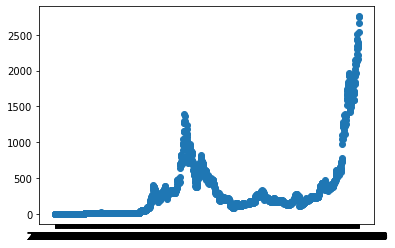

In [6]:
plt.scatter(DataSet['Date'],DataSet['Open'],)
plt.show()

base_treinamento = DataSet.iloc[:, 1:2].values

#DataSet.drop(['Date','Close','High','Low', 'Volume'],axis=1,inplace=True)

In [8]:
base_treinamento

array([[2.83162000e+00],
       [2.79376000e+00],
       [7.06136000e-01],
       ...,
       [2.66468555e+03],
       [2.74864966e+03],
       [2.75773413e+03]])

### Normalizar os dados do Mini Índice

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
DataScaled=scaler.fit_transform(base_treinamento)

In [10]:
print(DataScaled)

[[8.70427152e-04]
 [8.56696341e-04]
 [9.95708653e-05]
 ...
 [9.66253763e-01]
 [9.96705304e-01]
 [1.00000000e+00]]


### Definição dos previsores

In [18]:
previsores = []
preco_real = []
NRecursao = 90
DataSetLen = len(DataScaled)
print(DataSetLen)

2090


In [19]:

for i in range(NRecursao, DataSetLen):
    previsores.append(DataScaled[i-NRecursao:i,0])
    preco_real.append(DataScaled[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [20]:
previsores.shape

(2000, 90)

### Tranformar para o formato do Tensor do Keras

<br><img src="TensorKeras.png"><br>

In [21]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [22]:
previsores.shape

(2000, 90, 1)

### Estrutura da Rede Neural

In [23]:
# Camada de entrada
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

# Cada Oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 3
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Camada de Saída
regressor.add(Dense(units = 1, activation = 'linear'))


### Construindo a Rede

In [24]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
63/63 [==============================] - 18s 182ms/step - loss: 0.0106 - mean_absolute_error: 0.0587
Epoch 2/100
63/63 [==============================] - 11s 181ms/step - loss: 0.0032 - mean_absolute_error: 0.0332
Epoch 3/100
63/63 [==============================] - 11s 176ms/step - loss: 0.0027 - mean_absolute_error: 0.0317
Epoch 4/100
63/63 [==============================] - 11s 173ms/step - loss: 0.0026 - mean_absolute_error: 0.0285
Epoch 5/100
63/63 [==============================] - 11s 176ms/step - loss: 0.0022 - mean_absolute_error: 0.0284
Epoch 6/100
63/63 [==============================] - 11s 176ms/step - loss: 0.0020 - mean_absolute_error: 0.0280
Epoch 7/100
63/63 [==============================] - 12s 184ms/step - loss: 0.0020 - mean_absolute_error: 0.0256
Epoch 8/100
63/63 [==============================] - 12s 184ms/step - loss: 0.0021 - mean_absolute_error: 0.0266
Epoch 9/100
63/63 [==============================] - 12s 183ms/step - loss: 0.0016 - mean_absolu

### Conjunto de dados para o Teste

In [25]:
DataSet_teste=pd.read_csv('FuturosEthereum-teste.csv')

preco_real_teste = DataSet_teste.iloc[:, 1:2].values

base_completa = pd.concat((DataSet['Open'], DataSet_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values

entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)

In [26]:
DataSetTestLen = len(DataSet_teste)
NPredictions = 90

X_teste = []
for i in range(NRecursao, DataSetTestLen+NRecursao):
    X_teste.append(entradas[i-NRecursao:i, 0])
    
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)


In [27]:
RNN=[]
predictions_teste=X_teste[0].T
predictions_teste=np.reshape(predictions_teste, (predictions_teste.shape[0], predictions_teste.shape[1], 1))

predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
RNN.append(regressor.predict(predictions_teste)[0])

for i in range(NPredictions-1):
    predictions_teste=np.roll(predictions_teste,-1)
    predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
    RNN.append(regressor.predict(predictions_teste)[0])
RNN = scaler.inverse_transform(RNN)

print(RNN.mean())
print(previsoes.mean())
print(preco_real_teste.mean())

2096.7557163208708
2823.6003
3455.175944095238


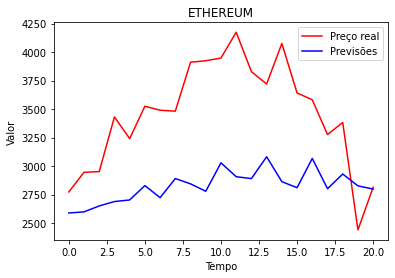

In [28]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
#plt.plot(RNN, color = 'green', label = 'RNN')

plt.title('ETHEREUM')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [29]:
np.shape(previsoes)

(21, 1)